# test moments_task_Npop

In [1]:
import numpy as np
from torch.utils.data import Dataset
import torch
from scipy.io import loadmat
from matplotlib import pyplot as plt

In [2]:
class moments_task_interpolate(Dataset):
    def __init__(self, r, contrasts, n_neurons, n_samples=1e4, n_steps_input=1e3):
        self.inputs = []
        self.outputs = []
        self.r = np.array(r)
        self.contrasts = np.array(contrasts)
        self.n_neurons = int(n_neurons)
        self.n_samples = int(n_samples)
        self.n_steps_input = int(n_steps_input)
 
        self.r_mean = np.zeros((len(r.keys()), len(self.contrasts))) # np.mean(r, axis=0)
        self.r_std = np.zeros((len(r.keys()), len(self.contrasts)))  # np.std(r, axis=0)
        self.k_mean = np.zeros((len(r.keys()), 3+1))
        self.k_std = np.zeros((len(r.keys()), 3+1))
        
        for i_pop, k_pop in enumerate(r.keys()):
            fig, axs = plt.subplots(2, 1, sharex=True)
            self.r_mean[i_pop] = np.mean(r[k_pop], axis=0)
            self.r_std[i_pop] = np.std(r[k_pop], axis=0)
            self.k_mean[i_pop] = np.polyfit(self.contrasts, self.r_mean[i_pop], 3)
            self.k_std[i_pop] = np.polyfit(self.contrasts, self.r_std[i_pop], 3)
            axs[0].plot(self.contrasts, self.r_mean[i_pop], label="mean data")
            axs[0].plot(self.contrasts, np.polyval(self.k_mean[i_pop], self.contrasts), label="mean interp")
            axs[1].plot(self.contrasts, self.r_std[i_pop], label="std data")
            axs[1].plot(self.contrasts, np.polyval(self.k_std[i_pop], self.contrasts), label="std interp")
            
        for i_sample in range(self.n_samples):
            contrast_sample = np.random.uniform(np.min(self.contrasts), np.max(self.contrasts))
            output_constant = np.zeros(len(r.keys())*2)
            for i_pop, k_pop in enumerate(r.keys()):
                mean_sample = np.polyval(self.k_mean[i_pop], contrast_sample)
                std_sample = np.polyval(self.k_std[i_pop], contrast_sample)
                output_constant[i_pop] = mean_sample
                output_constant[len(r.keys()) + i_pop] = std_sample**2
            input = np.ones((1, self.n_steps_input)) * contrast_sample
            output = np.tile(output_constant, (self.n_steps_input, 1))

            ##### pad input and ouput before and after gocue
            input_tensor = torch.from_numpy(input)
            output_tensor = torch.from_numpy(output)

            self.inputs.append(input_tensor)
            self.outputs.append(output_tensor)

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        return self.inputs[idx], self.outputs[idx], self.inputs[idx].shape[0]


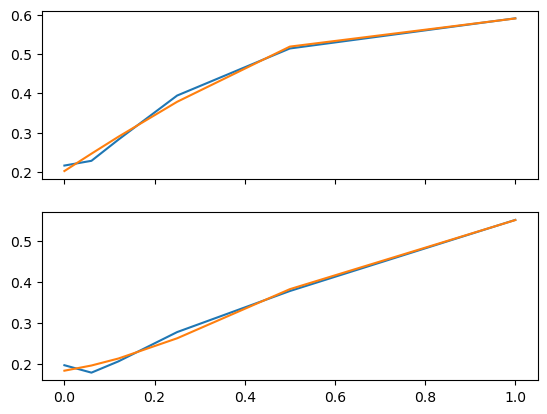

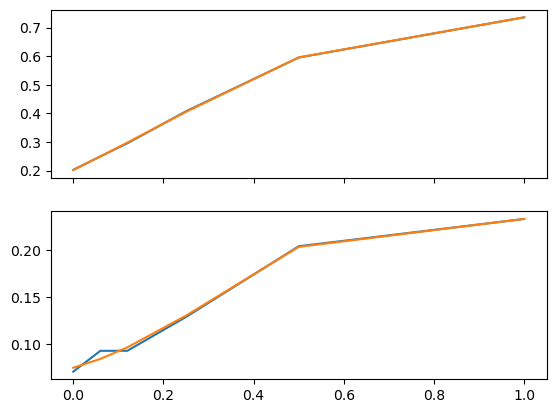

In [3]:
cell_label_list = ["pyr", "pv", "sst", "vip"]

# %% fetch data and define configurations
path_data = r"C:\Users\Roberto\Academics\courses\cajal_cn_2024\project\inference_theory\data\Data_cell_types_small_size.mat"
data_raw = loadmat(path_data)
contrast = np.squeeze(data_raw['contrast']) / 100
cell_activity = {}
cell_activity_all = {}
cell_activity_array = []
for k in data_raw.keys():
    if not k.startswith("_") and k != "contrast":
        cell_activity[k] = np.mean(data_raw[k], axis=0)
        cell_activity_all[k] = data_raw[k]



# define parameters for the task *task specific information that is not relevant for the network
cell_activity_sample = {}
cell_activity_sample["pyr"] = cell_activity_all["pyr"]
cell_activity_sample["pv"] = cell_activity_all["pv"]
config = {
    "r": cell_activity_sample,
    "contrasts": contrast,
    "n_neurons": 1e4
}

# create training data set
# dataset = moments_task_subsample(**config)
# dataset = moments_task_interpolate(**config)
dataset = moments_task_interpolate(**config)

In [ ]:
# TODO: change initialization to truncated normal